In [1]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import pathlib
import numpy as np

from fastai.tabular import *

In [2]:
path = pathlib.Path("data")
df_train = pd.read_csv(path / 'train.csv')
df_test  = pd.read_csv(path / 'test.csv')
df_subm  = pd.read_csv(path / 'sample_submission.csv')

print("Train:", df_train.shape)
print("Test:", df_test.shape)
df_train.head()

Train: (29000, 25)
Test: (1000, 24)


,Unnamed: 0,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,0,300000.0,1,1,1,45,-1,-1,-1,-1,...,6666.0,8333.0,8333.0,0.0,24000.0,6666.0,10000.0,8333.0,15449.0,1
1,1,90000.0,2,2,1,48,0,0,0,0,...,47193.0,48105.0,49327.0,1723.0,2393.0,2090.0,2000.0,2000.0,1803.0,0
2,2,360000.0,2,3,2,38,-1,-1,-1,-2,...,0.0,1444.0,-1382.0,3060.0,0.0,0.0,1444.0,1382.0,0.0,0
3,3,30000.0,2,2,1,30,-1,2,-1,-1,...,0.0,1083.0,3395.0,0.0,1000.0,398.0,1083.0,3395.0,7383.0,0
4,4,150000.0,2,3,1,48,0,0,0,2,...,39922.0,40953.0,42136.0,2000.0,4000.0,0.0,2000.0,2000.0,2000.0,0


### Check missing values: No

In [3]:
df_train.isnull().any().any()

False

### Check balance: Unbalanced

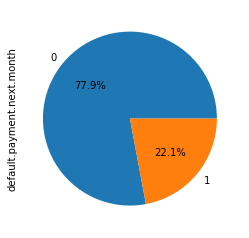

In [4]:
df_train['default.payment.next.month'].value_counts().plot.pie(autopct='%1.1f%%');

In [5]:
nominal = ["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", ]
numeric = ["LIMIT_BAL", "AGE", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "BILL_AMT4", "BILL_AMT5",
           "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
target  = "default.payment.next.month"

In [6]:
df_nominal = df_train[nominal]
df_nominal.nunique()

SEX           2
EDUCATION     7
MARRIAGE      4
PAY_0        11
PAY_2        11
PAY_3        11
PAY_4        11
PAY_5        10
PAY_6        10
dtype: int64

In [7]:
df_numeric = df_train[numeric]
df_numeric.describe()

,LIMIT_BAL,AGE,BILL_AMT4,BILL_AMT5,BILL_AMT6,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,29000.000000,2.900000e+04,29000.000000,29000.000000,29000.000000,29000.000000
mean,167433.782069,35.491241,43144.795310,40189.480724,38749.119448,43144.795310,40189.480724,38749.119448,5653.731069,5.929659e+03,5219.206724,4813.517793,4799.700724,5219.066931
std,129697.398166,9.230207,64168.203863,60625.599590,59372.108587,64168.203863,60625.599590,59372.108587,16591.601004,2.327732e+04,17538.709464,15544.667864,15337.748270,17828.678225
min,10000.000000,21.000000,-170000.000000,-81334.000000,-339603.000000,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,2338.750000,1759.000000,1250.750000,2338.750000,1759.000000,1250.750000,1000.000000,8.330000e+02,390.000000,298.750000,249.000000,122.750000
50%,140000.000000,34.000000,19037.000000,18091.000000,17067.500000,19037.000000,18091.000000,17067.500000,2100.000000,2.009000e+03,1804.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,54337.000000,50092.000000,49107.000000,54337.000000,50092.000000,49107.000000,5005.000000,5.000000e+03,4500.000000,4010.000000,4023.250000,4000.000000
max,1000000.000000,79.000000,891586.000000,927171.000000,961664.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


## Preprocess
Like transformations but you only do it once at the begining.

- **FillMissing**: Fill the missing values in continuous columns.
- **Categorify**: Transform the categorical variables to that type.
- **Normalize**: Normalize the continuous variables.

In [8]:
n_cv_folds = 10
x = df_train["AGE"].values
y = df_train["default.payment.next.month"].values
train_idxs_fold = []
valid_idxs_fold = []
cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)

In [9]:
procs = [Categorify, Normalize]

test = TabularList.from_df(df_test, path=path, cat_names=nominal, cont_names=numeric)
data = (TabularList.from_df(df_train, path=path, cat_names=nominal, cont_names=numeric, procs=procs)
                           .split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0])
                           .label_from_df(cols=target)
                           .add_test(test)
                           .databunch())

In [10]:
data.show_batch(rows=10)

SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,LIMIT_BAL,AGE,BILL_AMT4,BILL_AMT5,BILL_AMT6,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
2,3,2,2,2,2,0,0,0,0.5592,-0.8112,0.3025,-0.4926,-0.4703,0.3025,-0.4926,-0.4703,0.2646,-0.2488,-0.1364,-0.2771,-0.2777,-0.2745,1
1,1,1,0,0,0,0,0,0,2.5632,-0.3785,2.2188,2.3004,2.3524,2.2188,2.3004,2.3524,0.2540,0.2089,0.1135,0.0494,0.1307,0.0498,0
2,2,1,0,0,0,0,0,0,-0.6741,-1.0276,0.0025,0.0724,0.1174,0.0025,0.0724,0.1174,-0.2193,-0.1607,-0.1818,-0.1806,-0.1823,-0.1800,0
1,3,3,0,0,0,0,0,0,2.5632,1.8933,1.2768,1.4234,1.2717,1.2768,1.4234,1.2717,0.4220,0.2127,-0.0290,0.0767,0.4149,0.2653,0
2,2,2,-1,0,0,0,0,0,-0.6741,-1.3521,0.2489,0.1067,0.1480,0.2489,0.1067,0.1480,-0.1579,-0.1309,-0.1818,-0.1806,-0.1823,-0.1912,0
2,1,1,-1,-1,-1,-1,-1,-1,0.9445,0.2706,-0.4414,0.0854,-0.3989,-0.4414,0.0854,-0.3989,0.5500,0.0625,0.5577,2.6154,0.6866,0.2046,0
2,3,1,0,0,0,2,2,0,-1.0595,-0.8112,-0.4191,-0.4040,-0.3816,-0.4191,-0.4040,-0.3816,-0.2677,-0.1355,-0.2382,-0.3092,-0.2752,-0.2134,0
2,3,1,0,0,0,0,0,0,0.7904,0.8115,-0.1001,-0.1416,-0.1629,-0.1001,-0.1416,-0.1629,-0.2375,-0.1775,-0.2100,-0.2385,-0.2354,-0.2246,0
2,2,2,3,3,2,2,2,2,-0.3658,-1.1358,0.5152,0.5741,0.6083,0.5152,0.5741,0.6083,-0.3403,-0.1355,-0.1537,-0.1034,-0.1491,-0.2914,1
1,2,2,1,2,2,5,4,3,-1.1366,-1.1358,-0.4654,-0.4568,-0.4495,-0.4654,-0.4568,-0.4495,-0.2496,-0.1313,-0.2946,-0.3092,-0.3150,-0.2914,0


### Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01


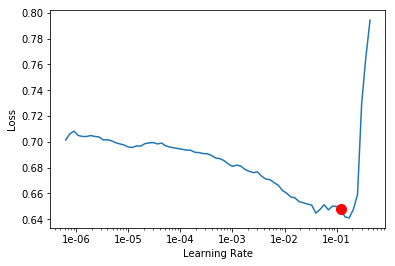

In [11]:
#f1 = partial(fbeta, beta=1)
#f1 = Fbeta_binary(beta2=1,clas = 1)
f1 = FBeta(beta=1)
#learn = tabular_learner(data, layers=[200,100], metrics=[accuracy,f1])
learn = tabular_learner(data, layers=[400,200], metrics=[accuracy,f1])

learn.lr_find()
learn.recorder.plot()

In [12]:
1.32E-02, 1e-2

(0.0132, 0.01)

In [13]:
learn.fit(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,f_beta
1,0.436825,4037.399170,0.259910,0.353508
2,0.429015,6361.441406,0.256808,0.353329
3,0.441908,6423.806152,0.260255,0.353225
4,0.432338,10069.631836,0.263702,0.353511
5,0.421175,8572321.000000,0.254395,0.352589
6,0.429469,9984.315430,0.256808,0.352941


KeyboardInterrupt: 